# Face Mask Detection

In [1]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
main_dir = r'C:\Users\MIHIR TAYSHETE\Coursera ML course\kaggle\input\covid-face-mask-detection-dataset\New Masks Dataset'
train_dir = os.path.join(main_dir,'Train')
test_dir = os.path.join(main_dir,'Test')
validation_dir = os.path.join(main_dir,'Validation')

train_mask_dir = os.path.join(train_dir,'Mask')
train_non_mask_dir = os.path.join(train_dir,'Non Mask')

In [4]:
train_mask_dir_names = os.listdir(train_mask_dir)
train_non_mask_dir_names = os.listdir(train_non_mask_dir)

print(train_mask_dir_names[:10])
print(train_non_mask_dir_names[:10])

['0003.jpg', '0006.jpg', '0018.jpg', '0019.jpg', '0022.jpg', '0027.jpg', '0029.jpg', '0037.jpg', '0040.jpg', '0042.jpg']
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '104.jpg', '105.jpg', '106.jpg', '107.jpg']


In [5]:
import matplotlib.image as npimg
nrows=4
ncols=4
plt.figure(figsize=(12,12))

mask_pic = []

for i in train_mask_dir_names[0:8]:
  mask_pic.append(os.path.join(train_mask_dir,i))

no_mask_pic = []

for i in train_non_mask_dir_names[0:8]:
  no_mask_pic.append(os.path.join(train_non_mask_dir,i))

<Figure size 864x864 with 0 Axes>

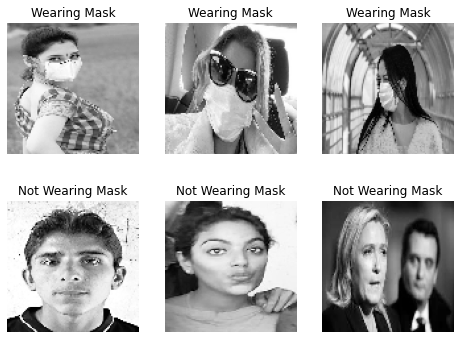

254 301


In [6]:
# get the list of jpegs from sub image class folders
mask = [fn for fn in os.listdir(f'{train_dir}\\Mask') if fn.endswith('.jpg')]
nmask = [fn for fn in os.listdir(f'{train_dir}\\Non Mask') if fn.endswith('.jpg')]
# randomly select 3 of each
select_mask = np.random.choice(mask, 3, replace = False)
select_nmask = np.random.choice(nmask, 3, replace = False)
# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/Mask/{select_mask[i]}'
        label = 'Wearing Mask'
    else:
        fp = f'{train_dir}/Non Mask/{select_nmask[i-3]}'
        label = 'Not Wearing Mask'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
print(len(mask), len(nmask))

In [7]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # to concatenate different images into the array
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            full_mat = img_ts
    return full_mat

# folders to matrix
mask_images = img2np(f'{train_dir}/Mask/', mask)
nmask_images = img2np(f'{train_dir}/Non Mask/', nmask)

print(mask_images)

[[245. 244. 239. ... 211. 216.  37.]
 [ 66.  30.  30. ...  50.  55.  59.]
 [ 89. 104. 111. ... 126. 123. 119.]
 ...
 [ 50.  67.  88. ...  20.  20.  21.]
 [ 22.   7.  43. ...  28.  10.  46.]
 [178. 176. 177. ... 201. 199. 200.]]


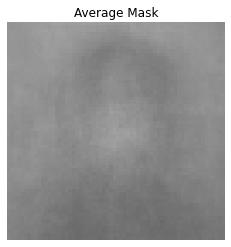

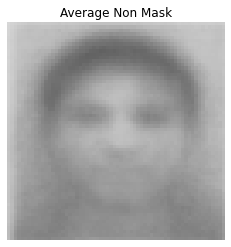

In [8]:
def find_mean_img(full_mat, title, size = (64, 64)):
    
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

mask_mean = find_mean_img(mask_images, 'Mask')
nmask_mean = find_mean_img(nmask_images, 'Non Mask')

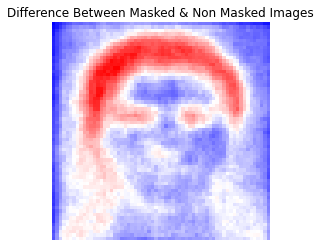

In [9]:
contrast_mean = mask_mean - nmask_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Masked & Non Masked Images')
plt.axis('off')
plt.show()

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_images_generator = train_datagen.flow_from_directory(train_dir,
                                                           target_size=(180,180),
                                                           batch_size=32,
                                                           class_mode='binary')

test_images_generator = test_datagen.flow_from_directory(test_dir,
                                                           target_size=(180,180),
                                                           batch_size=32,
                                                           class_mode='binary')

valid_images_generator = validation_datagen.flow_from_directory(validation_dir,
                                                           target_size=(180,180),
                                                           batch_size=32,
                                                           class_mode='binary')

Found 583 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 308 images belonging to 2 classes.


In [11]:
train_images_generator.class_indices

{'Mask': 0, 'Non Mask': 1}

In [12]:
train_images_generator.image_shape

(180, 180, 3)

***Building Convolutional neural network***

In [13]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='SAME',activation='relu',input_shape=(180,180,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0

In [14]:
model.compile(Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
history = model.fit(train_images_generator,epochs=200,validation_data=valid_images_generator)

Epoch 1/200
19/19 [==============================] - 21s 1s/step - loss: 1.8742 - accuracy: 0.5129 - val_loss: 0.6925 - val_accuracy: 0.7338
Epoch 2/200
19/19 [==============================] - 19s 978ms/step - loss: 0.6103 - accuracy: 0.6467 - val_loss: 0.5731 - val_accuracy: 0.8149
Epoch 3/200
19/19 [==============================] - 19s 998ms/step - loss: 0.4459 - accuracy: 0.8336 - val_loss: 0.5199 - val_accuracy: 0.7955
Epoch 4/200
19/19 [==============================] - 20s 1s/step - loss: 0.3837 - accuracy: 0.8834 - val_loss: 0.3130 - val_accuracy: 0.9026
Epoch 5/200
19/19 [==============================] - 19s 996ms/step - loss: 0.3131 - accuracy: 0.8937 - val_loss: 0.3336 - val_accuracy: 0.8474
Epoch 6/200
19/19 [==============================] - 18s 967ms/step - loss: 0.2983 - accuracy: 0.9057 - val_loss: 0.3659 - val_accuracy: 0.8701
Epoch 7/200
19/19 [==============================] - 18s 968ms/step - loss: 0.2606 - accuracy: 0.9091 - val_loss: 0.3025 - val_accuracy: 0.883

19/19 [==============================] - 16s 846ms/step - loss: 0.1760 - accuracy: 0.9331 - val_loss: 0.2959 - val_accuracy: 0.9058
Epoch 58/200
19/19 [==============================] - 16s 816ms/step - loss: 0.1710 - accuracy: 0.9365 - val_loss: 0.2907 - val_accuracy: 0.9188
Epoch 59/200
19/19 [==============================] - 15s 819ms/step - loss: 0.1654 - accuracy: 0.9365 - val_loss: 0.2976 - val_accuracy: 0.9156
Epoch 60/200
19/19 [==============================] - 16s 820ms/step - loss: 0.1576 - accuracy: 0.9451 - val_loss: 0.2786 - val_accuracy: 0.9156
Epoch 61/200
19/19 [==============================] - 16s 861ms/step - loss: 0.1584 - accuracy: 0.9400 - val_loss: 0.2537 - val_accuracy: 0.9188
Epoch 62/200
19/19 [==============================] - 16s 851ms/step - loss: 0.1601 - accuracy: 0.9485 - val_loss: 0.2341 - val_accuracy: 0.9091
Epoch 63/200
19/19 [==============================] - 17s 874ms/step - loss: 0.1422 - accuracy: 0.9451 - val_loss: 0.2397 - val_accuracy: 0.918

19/19 [==============================] - 16s 849ms/step - loss: 0.1116 - accuracy: 0.9537 - val_loss: 0.3106 - val_accuracy: 0.9156
Epoch 114/200
19/19 [==============================] - 16s 831ms/step - loss: 0.1183 - accuracy: 0.9485 - val_loss: 0.2995 - val_accuracy: 0.9123
Epoch 115/200
19/19 [==============================] - 16s 880ms/step - loss: 0.1042 - accuracy: 0.9605 - val_loss: 0.2719 - val_accuracy: 0.9156
Epoch 116/200
19/19 [==============================] - 16s 854ms/step - loss: 0.1171 - accuracy: 0.9554 - val_loss: 0.3278 - val_accuracy: 0.9058
Epoch 117/200
19/19 [==============================] - 16s 825ms/step - loss: 0.0911 - accuracy: 0.9640 - val_loss: 0.3151 - val_accuracy: 0.9058
Epoch 118/200
19/19 [==============================] - 16s 837ms/step - loss: 0.1259 - accuracy: 0.9365 - val_loss: 0.3593 - val_accuracy: 0.9026
Epoch 119/200
19/19 [==============================] - 16s 850ms/step - loss: 0.1200 - accuracy: 0.9537 - val_loss: 0.3146 - val_accuracy:

19/19 [==============================] - 15s 796ms/step - loss: 0.0831 - accuracy: 0.9691 - val_loss: 0.4020 - val_accuracy: 0.9221
Epoch 170/200
19/19 [==============================] - 15s 809ms/step - loss: 0.1010 - accuracy: 0.9554 - val_loss: 0.3802 - val_accuracy: 0.9156
Epoch 171/200
19/19 [==============================] - 16s 842ms/step - loss: 0.0884 - accuracy: 0.9571 - val_loss: 0.5046 - val_accuracy: 0.8831
Epoch 172/200
19/19 [==============================] - 16s 827ms/step - loss: 0.0889 - accuracy: 0.9554 - val_loss: 0.3684 - val_accuracy: 0.9058
Epoch 173/200
19/19 [==============================] - 16s 837ms/step - loss: 0.1028 - accuracy: 0.9520 - val_loss: 0.3940 - val_accuracy: 0.8994
Epoch 174/200
19/19 [==============================] - 16s 845ms/step - loss: 0.0859 - accuracy: 0.9503 - val_loss: 0.4924 - val_accuracy: 0.9058
Epoch 175/200
19/19 [==============================] - 16s 835ms/step - loss: 0.1211 - accuracy: 0.9588 - val_loss: 0.4109 - val_accuracy:

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'Epochs')

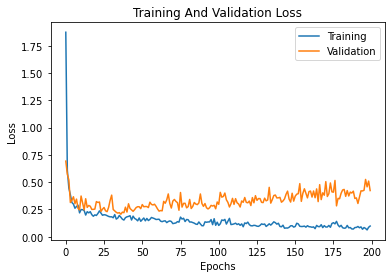

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title("Training And Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

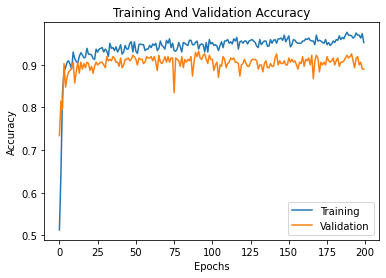

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training','Validation'])
plt.title("Training And Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

In [19]:
test_loss , test_acc = model.evaluate(test_images_generator)

print("Test Loss: {} Test Accuracy: {}".format(test_loss,test_acc))

4/4 [==============================] - 2s 406ms/step - loss: 0.2588 - accuracy: 0.8800
Test Loss: 0.2588026523590088 Test Accuracy: 0.8799999952316284


***As We See Our Model Is Not Overfitted.***

In [20]:
model.save('200epochs.h5')

In [21]:
import matplotlib.image as mpimg
from keras.preprocessing import image

def test_image_mask_nomask(path):
    im = mpimg.imread(path)
    plt.imshow(im)
    
    img = image.load_img(path,target_size=(180,180))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    prediction = model.predict(img)
    if prediction == 0:
        
        print("Person Wearing A Mask")

    else:
        print("Person Not Wearing A Mask")

Person Wearing A Mask


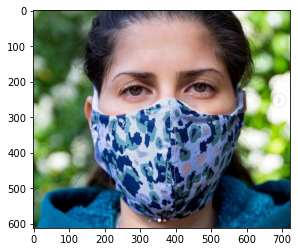

In [22]:
test_image_mask_nomask(r'C:\Users\MIHIR TAYSHETE\Coursera ML course\kaggle\input\covid-face-mask-detection-dataset\New Masks Dataset\Test\Mask/2265.png')

Person Not Wearing A Mask


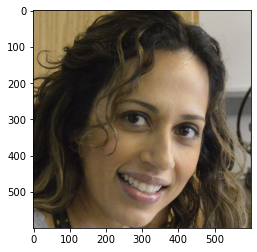

In [23]:
test_image_mask_nomask(r'C:\Users\MIHIR TAYSHETE\Coursera ML course\kaggle\input\covid-face-mask-detection-dataset\New Masks Dataset\Test\Non Mask/real_01050.jpg')